<hr>

<hr>

## 1. Eng-to-Ukr translation with a seq2seq Transformer

### Import of libraries

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import string
import re
import numpy as np

import tensorflow as tf

import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization

C:\Users\ivank\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


### Preparing the data

In [2]:
with open("./ukr-eng/ukr.txt", "r", encoding = "utf-8") as f:
    lines = f.read().split("\n")[:-1]
    
text_pairs = []
for line in lines:
    eng, ukr, _ = line.split("\t")
    ukr = "[start] " + ukr + " [end]"
    text_pairs.append((eng, ukr))

for _ in range(5):
    print(random.choice(text_pairs))

('You should not go alone.', '[start] Тобі не слід іти одному. [end]')
('Tom said that he heard three shots.', '[start] Том сказав, що він чув три вистріли. [end]')
('Tom stopped smiling.', '[start] Том припинив посміхатися. [end]')
('I arrived yesterday.', '[start] Я приїхала вчора. [end]')
('Have you finished your homework already?', '[start] Ти вже доробив домашку? [end]')


In [3]:
random.shuffle(text_pairs)
text_pairs = text_pairs[:100000]
num_val = int(0.15 * len(text_pairs))
num_train = len(text_pairs) - 2 * num_val
train_pairs = text_pairs[:num_train]
val_pairs = text_pairs[num_train : num_train + num_val]
test_pairs = text_pairs[num_train + num_val :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

100000 total pairs
70000 training pairs
15000 validation pairs
15000 test pairs


## Vectorizing the text data

In [4]:
strip_chars = string.punctuation.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocabulary_size = 15000
sequence_length = 20
batch_size = 64


def ukr_standardization(input_string):
    return tf.strings.regex_replace(tf.strings.lower(input_string), "[%s]" % re.escape(strip_chars), "")


eng_vector = keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

ukr_vector = keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=ukr_standardization,
)

train_eng = [pair[0] for pair in train_pairs]
train_ukr = [pair[1] for pair in train_pairs]
eng_vector.adapt(train_eng)
ukr_vector.adapt(train_ukr)

for v in [eng_vector, ukr_vector]:
    print(len(v.get_vocabulary()))
    print(v.get_vocabulary()[10:20])

8292
[np.str_('do'), np.str_('im'), np.str_('have'), np.str_('dont'), np.str_('was'), np.str_('in'), np.str_('me'), np.str_('mary'), np.str_('he'), np.str_('this')]
15000
[np.str_('на'), np.str_('Мері'), np.str_('ти'), np.str_('Тома'), np.str_('я'), np.str_('з'), np.str_('у'), np.str_('Це'), np.str_('У'), np.str_('в')]


In [5]:
def format_dataset(eng, ukr):
    eng = eng_vector(eng)
    ukr = ukr_vector(ukr)
    return ({ "encoder_inputs": eng, "decoder_inputs": ukr[:, :-1]}, ukr[:, 1:])

def make_dataset(pairs):
    eng_texts, ukr_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    ukr_texts = list(ukr_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, ukr_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

for inputs, targets in train_ds.take(1):
    print(f"inputs['encoder_inputs'].shape: {inputs['encoder_inputs'].shape}")
    print(f"inputs['decoder_inputs'].shape: {inputs['decoder_inputs'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['encoder_inputs'].shape: (64, 20)
inputs['decoder_inputs'].shape: (64, 20)
targets.shape: (64, 20)


### Building the model

* Filling of the seq2seq Transformer

In [16]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocabulary_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocabulary_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocabulary_size = vocabulary_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads

        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        self.dense_proj = keras.Sequential([
            layers.Dense(latent_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        dec_inputs, enc_outputs = inputs
        causal_mask = self.get_causal_attention_mask(dec_inputs)

        if mask is None:
            dec_padding_mask, enc_padding_mask = None, None
        else:
            dec_padding_mask, enc_padding_mask = mask

        # self-attn (causal)
        attn1 = self.attention_1(
            query=dec_inputs,
            value=dec_inputs,
            key=dec_inputs,
            attention_mask=causal_mask,
            query_mask=dec_padding_mask,
        )
        out1 = self.layernorm_1(dec_inputs + attn1)

        # cross-attn
        attn2 = self.attention_2(
            query=out1,
            value=enc_outputs,
            key=enc_outputs,
            query_mask=dec_padding_mask,
            key_mask=enc_padding_mask,
        )
        out2 = self.layernorm_2(out1 + attn2)

        proj = self.dense_proj(out2)
        return self.layernorm_3(out2 + proj)

    def get_causal_attention_mask(self, x):
        # x: (B, T, D)
        b = tf.shape(x)[0]
        t = tf.shape(x)[1]

        # (T, T) lower-triangular 1s
        mask = tf.linalg.band_part(tf.ones((t, t), dtype=tf.int32), -1, 0)
        # (B, T, T)
        mask = tf.expand_dims(mask, 0)
        return tf.tile(mask, [b, 1, 1])

* Assemble the end-to-end model

In [17]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
enc_x = PositionalEmbedding(sequence_length, vocabulary_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(enc_x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")

dec_x = PositionalEmbedding(sequence_length, vocabulary_size, embed_dim)(decoder_inputs)
dec_x = TransformerDecoder(embed_dim, latent_dim, num_heads)([dec_x, encoded_seq_inputs])
dec_x = layers.Dropout(0.5)(dec_x)
decoder_outputs = layers.Dense(vocabulary_size, activation="softmax")(dec_x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

transformer_outputs = decoder([decoder_inputs, encoder(encoder_inputs)])
transformer = keras.Model(
    {"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
    transformer_outputs,
    name="transformer",
)


### Training our model

In [18]:
epochs = 5

transformer.summary()
transformer.compile("rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_12       │ (None, None, 256) │  7,000,576 │ encoder_inputs[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_14       │ (None, None,      │ 12,959,640 │ decoder_inputs[0… │
│ (Functional)        │ 15000)            │            │ functional_12[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,960,216 (76.14 MB)

 Trainable params: 19,960,216 (76.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1544s 1s/step - accuracy: 0.5046 - loss: 3.6982 - val_accuracy: 0.5912 - val_loss: 2.7244
Epoch 2/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1508s 1s/step - accuracy: 0.6103 - loss: 2.6144 - val_accuracy: 0.6467 - val_loss: 2.2301
Epoch 3/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1546s 1s/step - accuracy: 0.6474 - loss: 2.2755 - val_accuracy: 0.6717 - val_loss: 2.0853
Epoch 4/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1508s 1s/step - accuracy: 0.6710 - loss: 2.0994 - val_accuracy: 0.6802 - val_loss: 1.9981
Epoch 5/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1678s 2s/step - accuracy: 0.6864 - loss: 1.9956 - val_accuracy: 0.6885 - val_loss: 2.0026


### Decoding test sentences

In [19]:
ukr_vocab = ukr_vector.get_vocabulary()
ukr_index_lookup = dict(zip(range(len(ukr_vocab)), ukr_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vector([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = ukr_vector([decoded_sentence])[:, :-1]
        predictions = transformer(
            {
                "encoder_inputs": tokenized_input_sentence,
                "decoder_inputs": tokenized_target_sentence,
            }
        )
        
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = ukr_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        
        if sampled_token == "[end]":
            break
    return decoded_sentence
    
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)

    print(f"<I>: {input_sentence}")
    print(f"<O>: {translated}")

<I>: We considered the problem from all angles.
<O>: [start] Ми [UNK] з [UNK] всі [UNK] [end]
<I>: Eat whatever you like.
<O>: [start] їм подобається [end]
<I>: Yesterday I helped my father.
<O>: [start] Я вчора допоміг свій батько [end]
<I>: Today, too, the temperature is below zero.
<O>: [start] Сьогодні занадто температура для того щоб [UNK] [end]
<I>: They were very popular.
<O>: [start] Вони були дуже Австралії [end]


<hr>

<hr>

2 завдання

In [2]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19

print("TF:", tf.__version__)


C:\Users\ivank\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TF: 2.20.0


2) Load + preprocess images

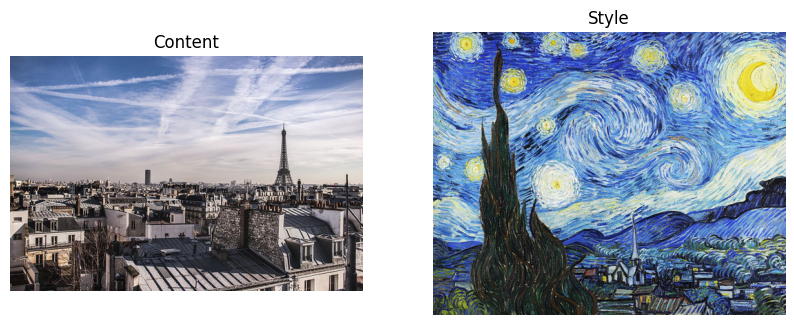

In [19]:
CONTENT_PATH = "content.jpg"
STYLE_PATH   = "style.jpg"

IMG_SIZE = 512  
def load_img(path, img_size=512):
    img = Image.open(path).convert("RGB")
    w, h = img.size
    scale = img_size / max(w, h)
    new_w, new_h = int(w * scale), int(h * scale)
    img = img.resize((new_w, new_h), Image.LANCZOS)
    img = np.array(img, dtype=np.float32)
    img = np.expand_dims(img, axis=0)
    return img

def preprocess(img):
    return vgg19.preprocess_input(img.copy())

def deprocess(x):
    x = x.copy()
    # vgg19 preprocess: BGR + mean
    x[..., 0] += 103.939
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    x = x[..., ::-1]  # BGR -> RGB
    x = np.clip(x, 0, 255).astype("uint8")
    return x[0]

content_img = load_img(CONTENT_PATH, IMG_SIZE)
style_img   = load_img(STYLE_PATH, IMG_SIZE)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(content_img[0].astype("uint8")); plt.title("Content"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(style_img[0].astype("uint8")); plt.title("Style"); plt.axis("off")
plt.show()


3) VGG19 feature extractor (content + style layers)

In [20]:
content_layers = ["block5_conv2"]
style_layers   = ["block1_conv1","block2_conv1","block3_conv1","block4_conv1","block5_conv1"]

def build_vgg_extractor():
    vgg = vgg19.VGG19(include_top=False, weights="imagenet")
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in (style_layers + content_layers)]
    model = tf.keras.Model(vgg.input, outputs)
    model.trainable = False
    return model

extractor = build_vgg_extractor()


4) Losses (style/content/total variation)

In [21]:
def gram_matrix(x):
    # x: [1, H, W, C]
    x = tf.squeeze(x, axis=0)          # [H,W,C]
    x = tf.reshape(x, [-1, x.shape[-1]])  # [HW, C]
    gram = tf.matmul(x, x, transpose_a=True)  # [C,C]
    return gram / tf.cast(tf.shape(x)[0], tf.float32)

def style_loss(style_outputs, gen_outputs):
    loss = 0.0
    for s, g in zip(style_outputs, gen_outputs):
        loss += tf.reduce_mean(tf.square(gram_matrix(s) - gram_matrix(g)))
    return loss / len(style_layers)

def content_loss(content_outputs, gen_outputs):
    return tf.reduce_mean(tf.square(content_outputs[0] - gen_outputs[0]))

def total_variation_loss(img):
    return tf.image.total_variation(img)

# Targets
content_targets = extractor(preprocess(content_img))[-len(content_layers):]
style_targets   = extractor(preprocess(style_img))[:len(style_layers)]


5) Optimize generated image

In [24]:
# ====== ВАГИ (можеш міняти) ======
STYLE_WEIGHT   = 1e-2
CONTENT_WEIGHT = 1e4
TV_WEIGHT      = 30.0

# ====== ІНІЦІАЛІЗАЦІЯ ======
generated = tf.Variable(content_img, dtype=tf.float32)

optimizer = tf.keras.optimizers.Adam(learning_rate=5.0)

# ====== TRAIN STEP (БЕЗ @tf.function) ======
def train_step():
    with tf.GradientTape() as tape:
        # VGG features
        outputs = extractor(vgg19.preprocess_input(tf.cast(generated, tf.float32)))

        gen_style   = outputs[:len(style_layers)]
        gen_content = outputs[-len(content_layers):]

        # losses
        s_loss = style_loss(style_targets, gen_style)
        c_loss = content_loss(content_targets, gen_content)
        tv     = tf.reduce_mean(tf.image.total_variation(generated))

        total_loss = (
            STYLE_WEIGHT * s_loss +
            CONTENT_WEIGHT * c_loss +
            TV_WEIGHT * tv
        )

    grads = tape.gradient(total_loss, generated)
    optimizer.apply_gradients([(grads, generated)])

    # обмеження пікселів
    generated.assign(tf.clip_by_value(generated, 0.0, 255.0))

    return total_loss, s_loss, c_loss, tv


step    1 | total=809022592.0000 | style=38531981312.0000 | content=0.0000


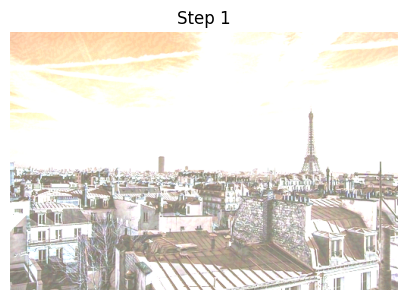

step   25 | total=281326752.0000 | style=2973207040.0000 | content=1178.1198


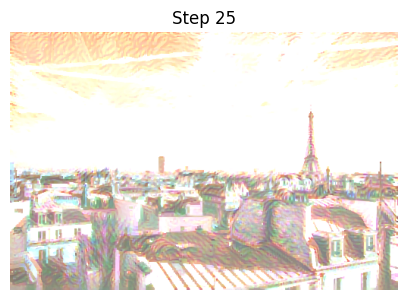

step   50 | total=209289392.0000 | style=2717212160.0000 | content=1078.4874


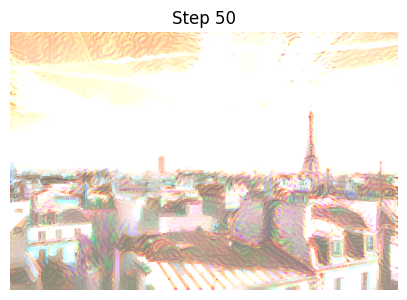

step   75 | total=186335632.0000 | style=2573748736.0000 | content=1053.5527


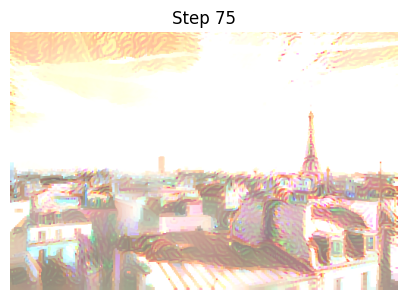

step  100 | total=174634304.0000 | style=2474267392.0000 | content=1053.7474


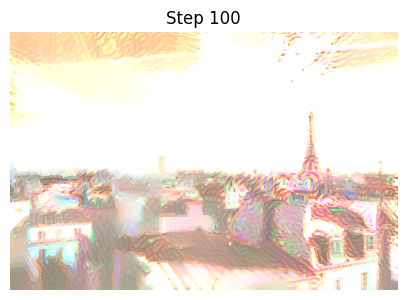

step  125 | total=166444000.0000 | style=2400391936.0000 | content=1064.1306


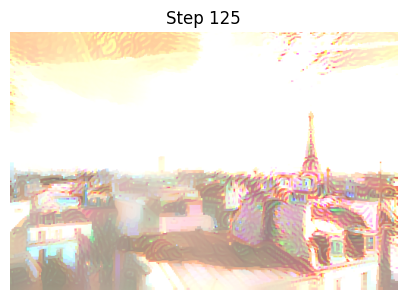

step  150 | total=160244576.0000 | style=2340382720.0000 | content=1073.5366


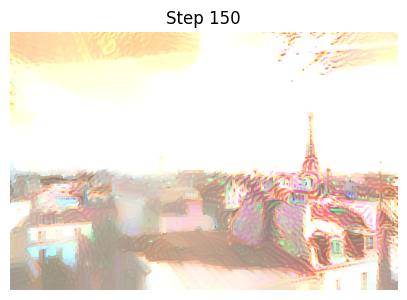

step  175 | total=155477648.0000 | style=2287199744.0000 | content=1079.1825


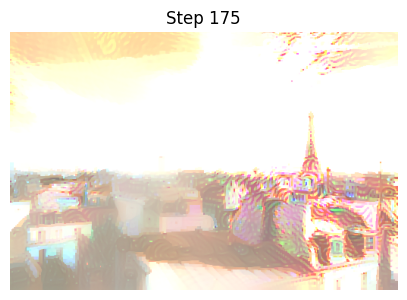

step  200 | total=151770256.0000 | style=2245614592.0000 | content=1084.0448


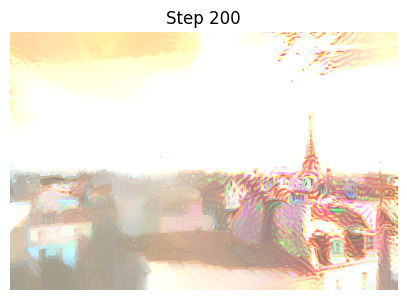

In [25]:
import matplotlib.pyplot as plt

EPOCHS = 200
LOG_EVERY = 25

for step in range(1, EPOCHS + 1):
    loss, s_loss, c_loss, tv = train_step()

    if step % LOG_EVERY == 0 or step == 1:
        print(
            f"step {step:4d} | "
            f"total={loss.numpy():.4f} | "
            f"style={s_loss.numpy():.4f} | "
            f"content={c_loss.numpy():.4f}"
        )

        preview = deprocess(generated.numpy())
        plt.figure(figsize=(5,5))
        plt.imshow(preview)
        plt.axis("off")
        plt.title(f"Step {step}")
        plt.show()


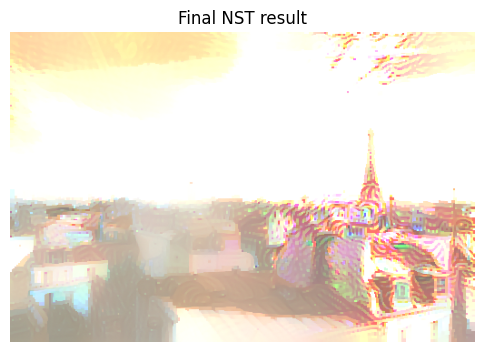

'nst_result.png'

In [26]:
from PIL import Image

result = deprocess(generated.numpy())

plt.figure(figsize=(6,6))
plt.imshow(result)
plt.axis("off")
plt.title("Final NST result")
plt.show()

Image.fromarray(result).save("nst_result.png")
"nst_result.png"


In [ ]:
3 завдання b) с)

In [2]:
import torch
from transformers import pipeline

device = 0 if torch.cuda.is_available() else -1
print("CUDA:", torch.cuda.is_available(), "| device:", device)


C:\Users\ivank\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\ivank\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


CUDA: False | device: -1


(b) Українські / UA-орієнтовані приклади через pipeline
1) Zero-shot classification (працює з укр текстом; модель MNLI/XNLI)

In [3]:
zsc = pipeline(
    "zero-shot-classification",
    model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli",
    device=device
)

text_ua = "У місті відкрили новий парк, висадили дерева та облаштували велодоріжки."
labels = ["екологія", "спорт", "освіта", "культура", "транспорт", "економіка"]

res = zsc(text_ua, candidate_labels=labels, hypothesis_template="Цей текст про {}.")
res


C:\Users\ivank\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ivank\.cache\huggingface\hub\models--MoritzLaurer--mDeBERTa-v3-base-mnli-xnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Device s

{'sequence': 'У місті відкрили новий парк, висадили дерева та облаштували велодоріжки.',
 'labels': ['спорт',
  'культура',
  'екологія',
  'транспорт',
  'освіта',
  'економіка'],
 'scores': [0.5981718301773071,
  0.2996070981025696,
  0.07815717160701752,
  0.019483376294374466,
  0.00408194400370121,
  0.0004985927371308208]}

2) Summarization (український текст → короткий підсумок)

In [4]:
summarizer = pipeline(
    "summarization",
    model="ukr-models/uk-summarizer",
    device=device
)

long_ua = """
У багатьох містах розвивають громадський транспорт і роблять вулиці зручнішими для пішоходів.
З’являються нові зелені зони, велосмуги, покращується освітлення та безбар’єрність.
Водночас залишаються проблеми з паркуванням, заторами та шумом у центральних районах.
Експерти радять поєднувати розвиток інфраструктури з просвітницькими кампаніями та
плануванням маршрутів, щоб мешканці частіше обирали екологічні способи пересування.
"""

summary = summarizer(long_ua, max_length=80, min_length=25, do_sample=False)
summary[0]["summary_text"]


C:\Users\ivank\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ivank\.cache\huggingface\hub\models--ukr-models--uk-summarizer. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Device set to use cpu
B

'У багатьох містах України розвивається інфраструктура, а також є проблеми з паркуванням, заторами та шумом у центральних районах. Про це йдеться у звіті Державної служби з питань інфраструктури.'

3) Translation (EN → UK)

In [5]:
translator_en_uk = pipeline(
    "translation",
    model="Helsinki-NLP/opus-mt-en-uk",
    device=device
)

en_text = "Urban parks improve air quality and make cities more comfortable for residents."
uk = translator_en_uk(en_text, max_length=128)
uk[0]["translation_text"]


Device set to use cpu


'Урбанічні парки поліпшують якість повітря і роблять міста більш зручними для мешканців.'

(c) Diffusers: Text-to-Image через pipeline

In [6]:
from diffusers import StableDiffusionPipeline
import time

model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
)
pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    pipe.enable_attention_slicing()


C:\Users\ivank\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\ivank\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ivank\.cache\huggingface\hub\models--runwayml--stable-diffusion-v1-5. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windo

100%|██████████| 30/30 [04:17<00:00,  8.60s/it]


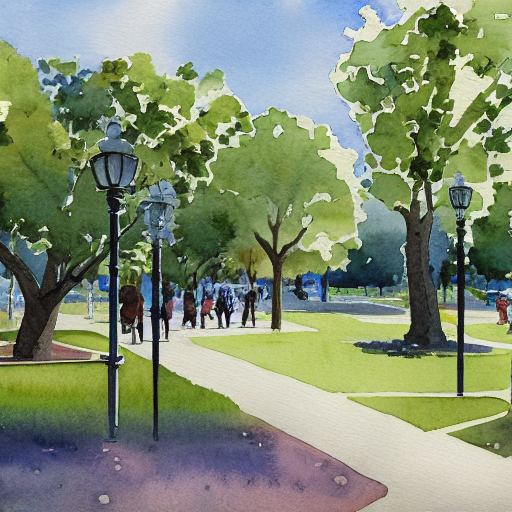

In [7]:
prompt = "A calm watercolor illustration of a city park in spring, soft light, highly detailed"
negative = "low quality, blurry, watermark, text"

img = pipe(
    prompt=prompt,
    negative_prompt=negative,
    num_inference_steps=30,
    guidance_scale=7.5,
    height=512,
    width=512
).images[0]

img


In [8]:
out_path = f"hf_diffusers_t2i_{int(time.time())}.png"
img.save(out_path)
out_path


'hf_diffusers_t2i_1766156380.png'